## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import seaborn as sns

In [2]:
# Load the train and test data.
mailout_train = pd.read_csv('./Udacity_MAILOUT_052018_TRAIN.csv')
mailout_test = pd.read_csv('./Udacity_MAILOUT_052018_TEST.csv')

# Load the attributes dataset.
dias_attributes = pd.read_excel('./DIAS Attributes - Values 2017.xlsx')

C:\Users\david\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
mailout_train.shape

(42962, 368)

In [4]:
mailout_test.shape

(42833, 367)

In [5]:
mail_response = mailout_train.RESPONSE.value_counts(dropna = False)
df_resp = pd.DataFrame({'RESPONSE':mail_response.index, '% of data': mail_response.values})
df_resp['% of data'] = 100 * df_resp['% of data']/mailout_train.shape[0]

In [6]:
mail_response

0    42430
1      532
Name: RESPONSE, dtype: int64

In [7]:
df_resp

,RESPONSE,% of data
0,0,98.761696
1,1,1.238304


#### **Discusion:**
**`98.76%` of the people who were contacted through the mailout did not become customers.  This dataset is very imbalanced.**

**The difference between the training and the test dataframes are the RESPONSE and Unnamed columns.**

In [8]:
def feature_correction(df, column):
    '''
    This function corrects the characters used in the CAMEO columns, which raised
    the erros when we load the population and customer datasets.
    '''
    columns = column
    
    # Replace and reformat the columns to float.
    df[columns] = df[columns].replace({'X': np.nan, 
                                       'XX': np.nan, 
                                       ' ': np.nan, 
                                       '': np.nan})
    if (column == 'CAMEO_DEUG_2015') or (column == 'CAMEO_INTL_2015'):
        df[columns] = df[columns].astype('float')
    
    return df

In [9]:
def dias_attributes_fix(attributes):
    '''
    Function reformats dias_attributes so that if is usable.
    Drops Unnamed: 0 columns, and moves the column names from
    the first row, forward fills the null values and generates
    a cols_to_keep 
    '''
    # Formating dais_attributes dataframe.
    attributes.drop(columns = 'Unnamed: 0', inplace = True)
    attributes.drop(index = 0, axis = 0, inplace = True)
    attributes.columns = ['Attribute',	'Description', 'Value', 'Meaning']
    attributes.reset_index(drop = True, inplace = True)
    
    # Lets fill the nan values with the previous values.
    attributes.fillna(method = 'ffill', inplace = True)

    cols_to_keep = attributes['Attribute'].unique().tolist()
    
    print('Dias_attributes has been transformed.')
    
    return attributes, cols_to_keep

In [10]:
attributes_df, cols_to_keep = dias_attributes_fix(dias_attributes)

Dias_attributes has been transformed.


In [11]:
def unknowns_df(attributes):
    '''
    This function formats the dais_attributes data and gives the unknown values
    in the data have been assigned.
    '''
    # drop the numerical values columns from attributes we wnat to keep them.
    #attributes = attributes.set_index('Attribute')
    #attributes = attributes.drop(['ANZ_HAUSHALTE_AKTIV',
    #                            'ANZ_HH_TITEL', 
    #                            'ANZ_PERSONEN', 
    #                            'ANZ_TITEL',
    #                            'GEBURTSJAHR',
    #                            'KBA13_ANZAHL_PKW',
    #                            'MIN_GEBAEUDEJAHR'], 
    #                          axis=0)
    
    #uk_attributes = attributes.reset_index()
    # which meaning might indicate unknowns.
    unknown = attributes[attributes['Meaning'].str.contains('unknown')]
    
    # Fix the cells with two values.
    unknown['Value'] = unknown['Value'].astype(str)
    unknown_2 = unknown['Value'].str.split(',').apply(pd.Series)
    unknown_2.index = unknown.set_index(['Attribute', 'Description', 'Meaning']).index
    unknown_2 = unknown_2.stack().reset_index(['Attribute', 'Description', 'Meaning'])
    unknown_2 = unknown_2.reset_index()
    unknown_2.drop(columns = 'index', inplace = True)
    unknown_2.rename(columns = {0: 'Value'}, inplace = True)
    
    # Convert the values into interger values.
    unknown_2['Value'] = unknown_2['Value'].astype('int64')
    
    return unknown_2

In [12]:
unknown_values_df = unknowns_df(attributes_df)

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
unknown_values_df['Value'].value_counts()

-1    230
 9     75
 0     19
Name: Value, dtype: int64

In [14]:
def clean_values(df, unknown_values_df, cols_to_keep, train = 'train'):
    '''
    This function converts the unknown values in the dataframe to null values,
    drops rows that have more than 50% missing data and drop columns we have no
    definitions for in attributes.
    '''
    # Drop the Unnamed:0 column in the data
    if 'Unnamed: 0' in df.columns:
        df.drop(columns = 'Unnamed: 0', inplace = True)
    
    iden = df.pop('LNR')
    # Fix the CAMEO_DEU_2015 missing values recorded as 'X' or 'XX'.
    df = feature_correction(df, column = 'CAMEO_DEUG_2015')
    df = feature_correction(df, column = 'CAMEO_DEU_2015')

    # Takes the unknown values recorded in Meaning and change them in df for null.
    print('-------------------------------------------------------------')
    print('----- Converting unknown values to null in training df. -----')
    print('-------------------------------------------------------------')
    #---------------------------------------------------------------------------------------
    for row in unknown_values_df.iterrows():
        missing_values = int(row[1]['Value'])
        attrib = row[1]['Attribute']
        
        if attrib not in df.columns:
            continue
        
        if isinstance(missing_values, int):
            df[attrib].replace(missing_values, np.nan, inplace=True)
        elif isinstance(missing_values, str):
            eval("df[dias_attributes].replace(["+missing_values+"], np.nan, inplace=True)")
    
    print('-------------------------------------------------------------')
    print('-------------- Conversion of data complete. -----------------')
    print('-------------------------------------------------------------')
    
    if train == 'train':
        # Assess how many missing values per row then remove those over 50%.
        row_nulls = df.isnull().sum(axis = 1)
        cols_len = df.shape[1]
        df = df.loc[row_nulls[row_nulls <= 0.5 * cols_len].index]
        df.reset_index(drop = True, inplace = True)
        
        
        # Split the features and lebels
        train_response = df['RESPONSE']
        features = df.drop('RESPONSE', axis = 1)
        
        features = features.filter(cols_to_keep)
        
        print('-------------------------------------------------------------')
        print('----------  features and train_response ready. --------------')
        print('-------------------------------------------------------------')
        
        return features, train_response, iden
    elif train == 'customers':
        # For the customer data take the customer specific columns.
        cust_response = df[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']]
        features = df.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], 
                           axis = 1)
        features = features.filter(cols_to_keep)
        
        print('-------------------------------------------------------------')
        print('-------------  customer features and type ready -------------')
        print('-------------------------------------------------------------')
        
        return features, cust_response, iden
        
    else:
        # Drop columns not in attributes.
        features = df.filter(cols_to_keep)
        
        print('-------------------------------------------------------------')
        print('-------------------  features ready -------------------------')
        print('-------------------------------------------------------------')
        
        return features, iden

In [15]:
train_features, train_response, train_lrn  = clean_values(mailout_train, 
                             unknown_values_df, 
                             cols_to_keep, 
                             train = 'train')

-------------------------------------------------------------
----- Converting unknown values to null in training df. -----
-------------------------------------------------------------
-------------------------------------------------------------
-------------- Conversion of data complete. -----------------
-------------------------------------------------------------
-------------------------------------------------------------
----------  features and train_response ready. --------------
-------------------------------------------------------------


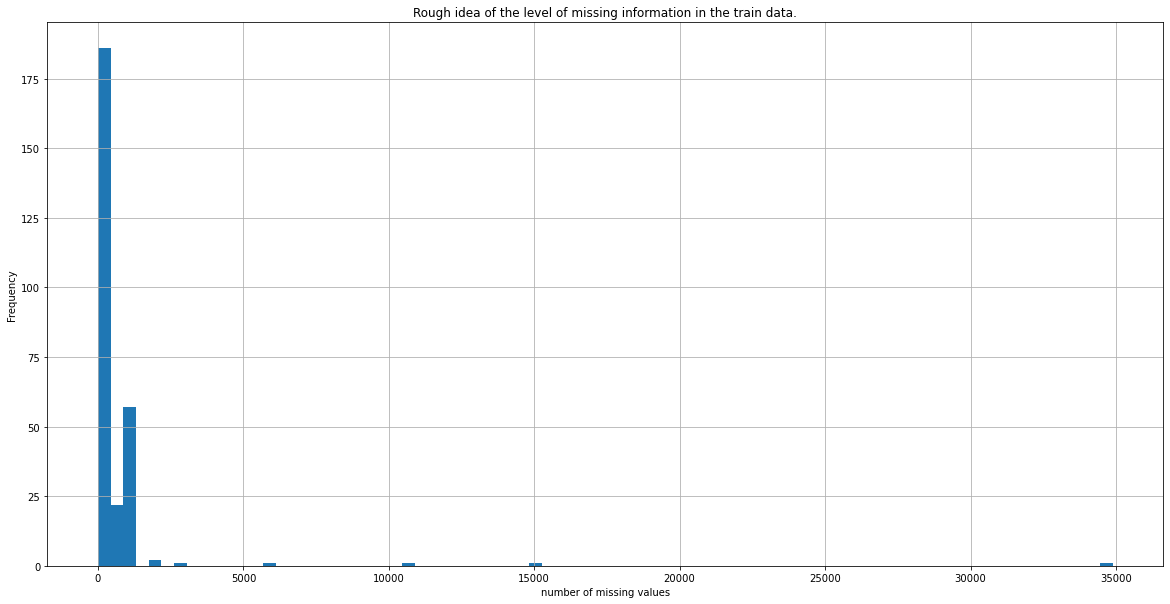

In [16]:
# Missining values in pop_features.
train_features.isnull().sum().plot(kind='hist', bins = 80, figsize = (20,10));
plt.title('Rough idea of the level of missing information in the train data.')
plt.xlabel('number of missing values')
plt.grid()

There are fewer columns that have a large number of missing values but to know more we should dig a little more.  First lets look at how much data is missing from the test data.

In [17]:
test_features, test_lrn  = clean_values(mailout_test, 
                             unknown_values_df, 
                             cols_to_keep, 
                             train = 'test')

-------------------------------------------------------------
----- Converting unknown values to null in training df. -----
-------------------------------------------------------------
-------------------------------------------------------------
-------------- Conversion of data complete. -----------------
-------------------------------------------------------------
-------------------------------------------------------------
-------------------  features ready -------------------------
-------------------------------------------------------------


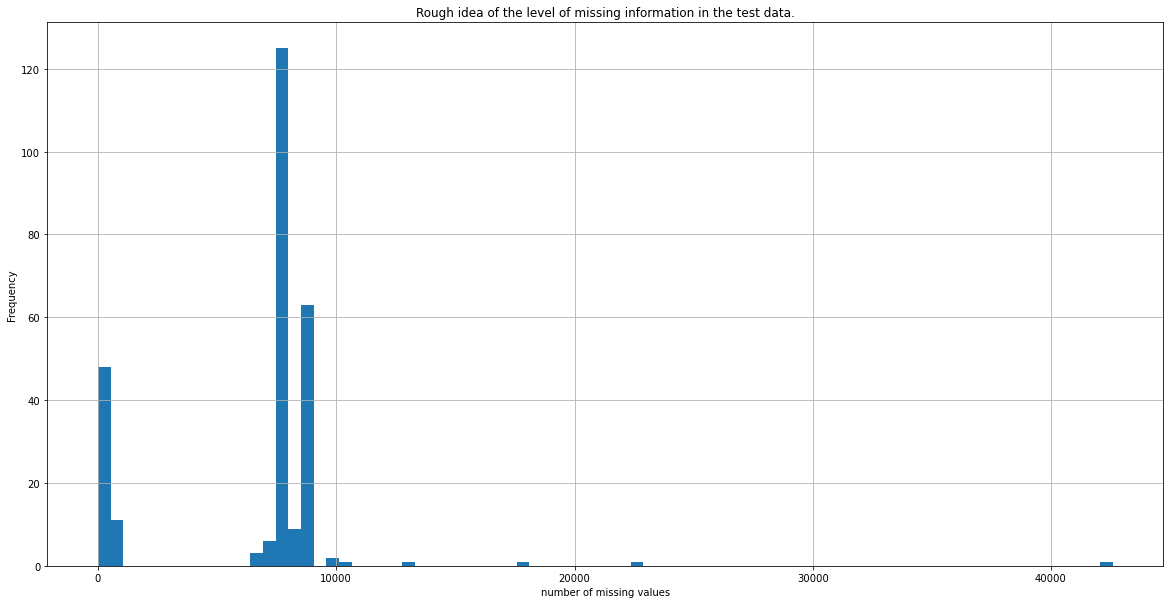

In [18]:
# Missining values in pop_features.
test_features.isnull().sum().plot(kind='hist', bins = 80, figsize = (20,10));
plt.title('Rough idea of the level of missing information in the test data.')
plt.xlabel('number of missing values')
plt.grid()

It appears at fist glace that there is more missing data in the test dataset that in the training dataset.

In [19]:
train_missing_over30p = train_features.isnull().mean()[train_features.isnull().mean() > 0.3] * 100
train_missing_over30p.reset_index().rename({'index': 'Attribute', 0: '% missing'}, axis = 1)

,Attribute,% missing
0,AGER_TYP,30.506639
1,KBA05_BAUMAX,43.070040
2,TITEL_KZ,99.407306


In [20]:
test_missing_over30p = test_features.isnull().mean()[test_features.isnull().mean() > 0.3] * 100
test_missing_over30p.reset_index().rename({'index': 'Attribute', 0: '% missing'}, axis = 1)

,Attribute,% missing
0,AGER_TYP,42.016669
1,ALTER_HH,30.889735
2,KBA05_BAUMAX,53.286018
3,TITEL_KZ,99.425676


Let's drop these 4 coulumns from both datasets.

In [21]:
# Dropping these 4 columns.
train_features.drop(['AGER_TYP', 'ALTER_HH', 'KBA05_BAUMAX', 'TITEL_KZ'], axis = 1, inplace=True)
test_features.drop(['AGER_TYP', 'ALTER_HH', 'KBA05_BAUMAX', 'TITEL_KZ'], axis = 1, inplace=True)

In [22]:
print('Training data shape: ', train_features.shape)
print('Test data shape: ', test_features.shape)

Training data shape:  (35094, 268)
Test data shape:  (42833, 268)


In [23]:
# Best columns to keep.
#best_cols = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_TITEL',
#             'CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
#             'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12',
#             'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
#             'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
#             'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
#             'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12',
#             'D19_VERSI_ANZ_24', 'EWDICHTE', 'FINANZTYP', 'FINANZ_ANLEGER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
#             'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GEBURTSJAHR',
#             'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HH_EINKOMMEN_SCORE', 'KBA05_ALTER4', 'KBA05_ANTG2', 'KBA05_ANTG4',
#             'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_KRSAQUOT',
#             'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSZUL', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXBJ',
#             'KBA05_MAXSEG', 'KBA05_MOD1', 'KBA05_MOD3', 'KBA05_MOD8', 'KBA05_MOTOR', 'KBA05_SEG10', 'KBA05_SEG4', 'KBA05_SEG5',
#             'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_VORB0', 'KBA05_ZUL1', 'KBA05_ZUL2', 'KBA05_ZUL4',
#             'KBA13_ALTERHALTER_45', 'KBA13_ALTERHALTER_61', 'KBA13_ANZAHL_PKW', 'KBA13_AUDI', 'KBA13_BMW', 'KBA13_CCM_1500',
#             'KBA13_CCM_2000', 'KBA13_CCM_2500', 'KBA13_CCM_2501', 'KBA13_CCM_3000', 'KBA13_CCM_3001', 'KBA13_FIAT',
#             'KBA13_HALTER_40', 'KBA13_HALTER_45', 'KBA13_HALTER_55', 'KBA13_HALTER_65', 'KBA13_HALTER_66',
#             'KBA13_HERST_AUDI_VW', 'KBA13_HERST_BMW_BENZ', 'KBA13_HERST_EUROPA', 'KBA13_HERST_FORD_OPEL', 'KBA13_KMH_140',
#             'KBA13_KMH_211', 'KBA13_KMH_250', 'KBA13_KMH_251', 'KBA13_KRSHERST_AUDI_VW', 'KBA13_KRSHERST_BMW_BENZ',
#             'KBA13_KRSZUL_NEU', 'KBA13_KW_121', 'KBA13_MERCEDES', 'KBA13_MOTOR', 'KBA13_OPEL', 'KBA13_PEUGEOT',
#             'KBA13_SEG_GROSSRAUMVANS', 'KBA13_SEG_MINIVANS', 'KBA13_SEG_MINIWAGEN', 'KBA13_SEG_OBEREMITTELKLASSE',
#             'KBA13_SEG_OBERKLASSE', 'KBA13_SEG_SPORTWAGEN', 'KBA13_SEG_UTILITIES', 'KBA13_SEG_VAN', 'KBA13_SITZE_4',
#             'KBA13_SITZE_5', 'KBA13_SITZE_6', 'KBA13_VORB_0', 'KBA13_VW', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
#             'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'MIN_GEBAEUDEJAHR',
#             'ONLINE_AFFINITAET', 'ORTSGR_KLS9', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX',
#             'PLZ8_GBZ', 'PLZ8_HHZ', 'PRAEGENDE_JUGENDJAHRE', 'RELAT_AB', 'RETOURTYP_BK_S', 'SEMIO_DOM', 'SEMIO_ERL',
#             'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT', 'SEMIO_LUST', 'SEMIO_PFLICHT', 'SEMIO_RAT',
#             'SEMIO_REL', 'SEMIO_SOZ', 'SEMIO_VERT', 'SHOPPER_TYP', 'VERS_TYP', 'WOHNDAUER_2008', 'W_KEIT_KIND_HH',
#             'ZABEOTYP', 'CAMEO_DEU_2015_2D', 'CAMEO_DEU_2015_5D', 'CAMEO_DEU_2015_6B', 'CAMEO_DEU_2015_7B',
#             'CAMEO_DEU_2015_7C', 'CAMEO_DEU_2015_9E', 'OST_WEST_KZ_W']

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE
#from imblearn.over_sampling import SVMSMOTE
#from imblearn.under_sampling import RandomUnderSampler, NearMiss

Convert categorical data to dummy variables then Impute, decopmose and scale the data before passing through modelling.

In [25]:
# Create dummy columns from the categorical data.
def create_dummy_df(df, cat_cols, dummy_na=False):
    '''
    Function finds all categorical columns, creats dummy variables and deletes the original.
    
    Inputs:
        df - dataframe to use.
        cat_cols - a list of the categorical column in the dataframe.
        dummy_na - Set to false.
        
    Output:
       df - dataframe with the categorical columns replaced with their dummy variables.
    '''
    for col in cat_cols:
        try:
            # for eact category add a dummy variable and drop the original colunn.
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
            
        except:
            continue
    return df

In [26]:
# Create the dummy features from the categorical data in the training dataset.
train_cat_df = train_features.select_dtypes(include='object')
train_cat_cols = train_cat_df.columns

# Create the dummy variables from the categorical columns in df.
train_data_dum = create_dummy_df(train_features, train_cat_cols, dummy_na=False)

In [27]:
# Create the dummy features from the categorical data in the test datset.
test_cat_df = test_features.select_dtypes(include='object')
test_cat_cols = test_cat_df.columns

# Create the dummy variables from the categorical columns in df.
test_data_dum = create_dummy_df(test_features, test_cat_cols, dummy_na=False)

In [28]:
imputer = SimpleImputer(strategy='most_frequent')

# Impute the training data with most frequent values.
train_features_im = pd.DataFrame(imputer.fit_transform(train_data_dum.values),
                                columns = train_data_dum.columns)

# Impute the test data with most frequent values.
test_features_im = pd.DataFrame(imputer.fit_transform(test_data_dum.values),
                                columns = test_data_dum.columns)

In [29]:
# used to check if there are any missing values.
#train_missing = train_features_im.isnull().mean()[train_features_im.isnull().mean() > 0] * 100
#train_missing.reset_index().rename({'index': 'Attribute', 0: '% missing'}, axis = 1)

In [30]:
#train_features_im = train_features_im[best_cols]
#test_features_im = test_features_im[best_cols]

In [54]:
# Fixing the imbalance using over sampling.
smote = SMOTETomek(sampling_strategy='auto', random_state=42)
#smote = NearMiss(version=1)
X_sm, y_sm = smote.fit_sample(train_features_im, train_response)

In [55]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
import xgboost as xgb

In [89]:
# Create a train_test_split of the training data.
X_train, X_test, y_train, y_test = train_test_split(train_features_im, 
                                                    train_response, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [84]:
print('Training data dummy, scaled and imputed: ', train_features_im.shape)
print('Test data dummy, scaled and imputed: ', test_features_im.shape)

Training data dummy, scaled and imputed:  (35094, 310)
Test data dummy, scaled and imputed:  (42833, 310)


In [85]:
# instatiate the model.
#rf = RandomForestRegressor()

In [86]:
#rf.get_params()

In [37]:
#parameters = {
#    'max_depth': [7],
#    'min_samples_leaf': [50],
#    'n_estimators': [500]
#}

In [38]:
#rf_model = GridSearchCV(rf, 
#                        param_grid = parameters, 
#                        cv = model_selection.KFold(5),
#                        n_jobs = -1)

In [39]:
#rf_model.fit(X_train, y_train)

In [40]:
#rf_model.best_params_

This is a record of the hyperparameters used in the Gridsearch.

`GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [7, 9, 12],
                         'min_samples_leaf': [2, 10, 25, 50],
                         'n_estimators': [100, 200, 500]})`
                         
The best_params_ were `{'max_depth': 7, 'min_samples_leaf': 50, 'n_estimators': 500}`

In [41]:
#y_pred = rf_model.predict(X_test)

In [42]:
#rf_model.score(X_train, y_train)

In [43]:
# function for modeling and cross-validation


#def modelval(alg, X_train, y_train, useTrainCV=True,
#             cv_folds=5, early_stopping_rounds=50):
#    
#    if useTrainCV:
#        xgb_param = alg.get_xgb_params()
#        xgtrain = xgb.DMatrix(X_train, label=y_train)
#        
#        cvresult = xgb.cv(xgb_param, xgtrain,
#                          num_boost_round=alg.get_params()[
#                              'n_estimators'], nfold=cv_folds,
#                          metrics='auc', verbose_eval=20,
#                          early_stopping_rounds=early_stopping_rounds,
#                          shuffle=True)
#        
#        alg.set_params(n_estimators=cvresult.shape[0])
#        
#        print('n_estimators=', cvresult.shape[0])
#        
#    # cross-validation
#    all_auc = cross_val_score(alg, X_train, y_train,
#                              scoring='roc_auc', cv=5,
#                              n_jobs=-1, verbose=10
#                             )
#    
#    auc = np.average(all_auc)
#    print("AUC Score : %f" % auc)

In [44]:
#xgb1 = XGBRegressor(
#        learning_rate=0.08,
#        n_estimators=1000,
#        max_depth=3,
#        min_child_weight=5,
#        gamma=0.4,
#        subsample=0.8,
#        colsample_bytree=0.8,
#        objective='binary:logistic',
#        nthread=4,
#        scale_pos_weight=1,
#        seed=27,
#        random_state=42)
#
#modelval(xgb1, X_train, y_train)

In [45]:
#xgb1_pred = xgb1.evals_result?

In [46]:
#xgb1_pred = xgb1.evals_result

In [47]:
#xgb1_pred = xgb1.evals_result

In [48]:
#xgb1_pred = xgb1.evals_result

In [59]:
from skopt import gp_minimize, BayesSearchCV
from skopt.space import Real, Integer
from functools import partial
from sklearn.metrics import auc
from sklearn.model_selection import StratifiedKFold

In [90]:
xgb3 = BayesSearchCV(estimator=XGBRegressor(objective= 'binary:logistic',
                                          eval_metric = 'auc'),
                     search_spaces = {
                         'colsample_bytree': (0.01, 1.0, 'uniform'),
                         'gamma': (0.01, 1.0, 'uniform'),
                         'learning_rate': (0.01, 1.0, 'log-uniform'),
                         'max_depth': (1, 50),
                         'subsample': (0.01, 1.0, 'uniform'),
                         'reg_lambda': (1e-5, 1000, 'log-uniform'),
                         'reg_alpha': (1e-5, 1.0, 'log-uniform'),
                         'min_child_weight': (1, 10),
                         'n_estimators': (50, 100),
                         'scale_pos_weight': (1e-5, 500, 'log-uniform')
                     },
                     scoring = 'roc_auc',
                     cv = StratifiedKFold(
                         n_splits=3,
                         shuffle=True,
                         random_state=42
                     ),
                     n_iter = 20,
                     verbose = 0,
                     refit = True,
                     random_state = 42)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(xgb3.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(xgb3.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(xgb3.best_score_, 4),
        xgb3.best_params_
    ))
    
    # Save all model results
    clf_name = xgb3.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [91]:
result = xgb3.fit(X_train.values, y_train.values, callback=status_print)

Model #1
Best ROC-AUC: 0.5774
Best params: OrderedDict([('colsample_bytree', 0.4160029192647807), ('gamma', 0.7304484857455519), ('learning_rate', 0.7340675018434776), ('max_depth', 16), ('min_child_weight', 7), ('n_estimators', 71), ('reg_alpha', 0.0005684034097210145), ('reg_lambda', 740), ('scale_pos_weight', 152), ('subsample', 0.6513136724634089)])

Model #2
Best ROC-AUC: 0.6344
Best params: OrderedDict([('colsample_bytree', 0.8390144719977516), ('gamma', 0.8844821246070537), ('learning_rate', 0.04044084484117812), ('max_depth', 48), ('min_child_weight', 9), ('n_estimators', 53), ('reg_alpha', 4.915216946847741e-05), ('reg_lambda', 354), ('scale_pos_weight', 318), ('subsample', 0.9539453486878958)])

Model #3
Best ROC-AUC: 0.6344
Best params: OrderedDict([('colsample_bytree', 0.8390144719977516), ('gamma', 0.8844821246070537), ('learning_rate', 0.04044084484117812), ('max_depth', 48), ('min_child_weight', 9), ('n_estimators', 53), ('reg_alpha', 4.915216946847741e-05), ('reg_lambda

ValueError: All integer values shouldbe greater than 0.000010

In [ ]:
xgb3.best_params_

In [76]:
param_dist = {
    'learning_rate':0.04044084484117812,
    'n_estimators':53,
    'max_depth':48,
    'min_child_weight':9,
    'gamma':0.8844821246070537,
    'subsample':0.9539453486878958,
    'colsample_bytree':0.8390144719977516,
    'objective':'binary:logistic',
    'nthread':4,
    'scale_pos_weight':318,
    'seed':27,
    'random_state':42,
    #'alpha':1.7570205641667407e-08,
    'lambda':354
}

xgb2 = xgb.XGBModel(**param_dist)

xgb2.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='auc',
        verbose=True,
        early_stopping_rounds=20)

[0]	validation_0-auc:0.70358	validation_1-auc:0.58100
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.70381	validation_1-auc:0.59221
[2]	validation_0-auc:0.73436	validation_1-auc:0.59552
[3]	validation_0-auc:0.76566	validation_1-auc:0.59490
[4]	validation_0-auc:0.77890	validation_1-auc:0.60063
[5]	validation_0-auc:0.82393	validation_1-auc:0.59793
[6]	validation_0-auc:0.86078	validation_1-auc:0.60054
[7]	validation_0-auc:0.87174	validation_1-auc:0.60400
[8]	validation_0-auc:0.88790	validation_1-auc:0.60528
[9]	validation_0-auc:0.89055	validation_1-auc:0.60321
[10]	validation_0-auc:0.89898	validation_1-auc:0.59961
[11]	validation_0-auc:0.89926	validation_1-auc:0.60337
[12]	validation_0-auc:0.90945	validation_1-auc:0.60574
[13]	validation_0-auc:0.91818	validation_1-auc:0.60760
[14]	validation_0-auc:0.91814	validation_1-auc:0.60689
[15]	validation_0-auc:0.9207

XGBModel(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=0.8390144719977516,
         gamma=0.8844821246070537, gpu_id=-1, interaction_constraints='',
         lambda=354, learning_rate=0.04044084484117812, max_delta_step=0,
         max_depth=48, min_child_weight=9, monotone_constraints='()',
         n_estimators=53, n_jobs=4, nthread=4, num_parallel_tree=1,
         objective='binary:logistic', random_state=42, reg_alpha=0,
         reg_lambda=354, scale_pos_weight=318, seed=27,
         subsample=0.9539453486878958, tree_method='exact',
         validate_parameters=1)

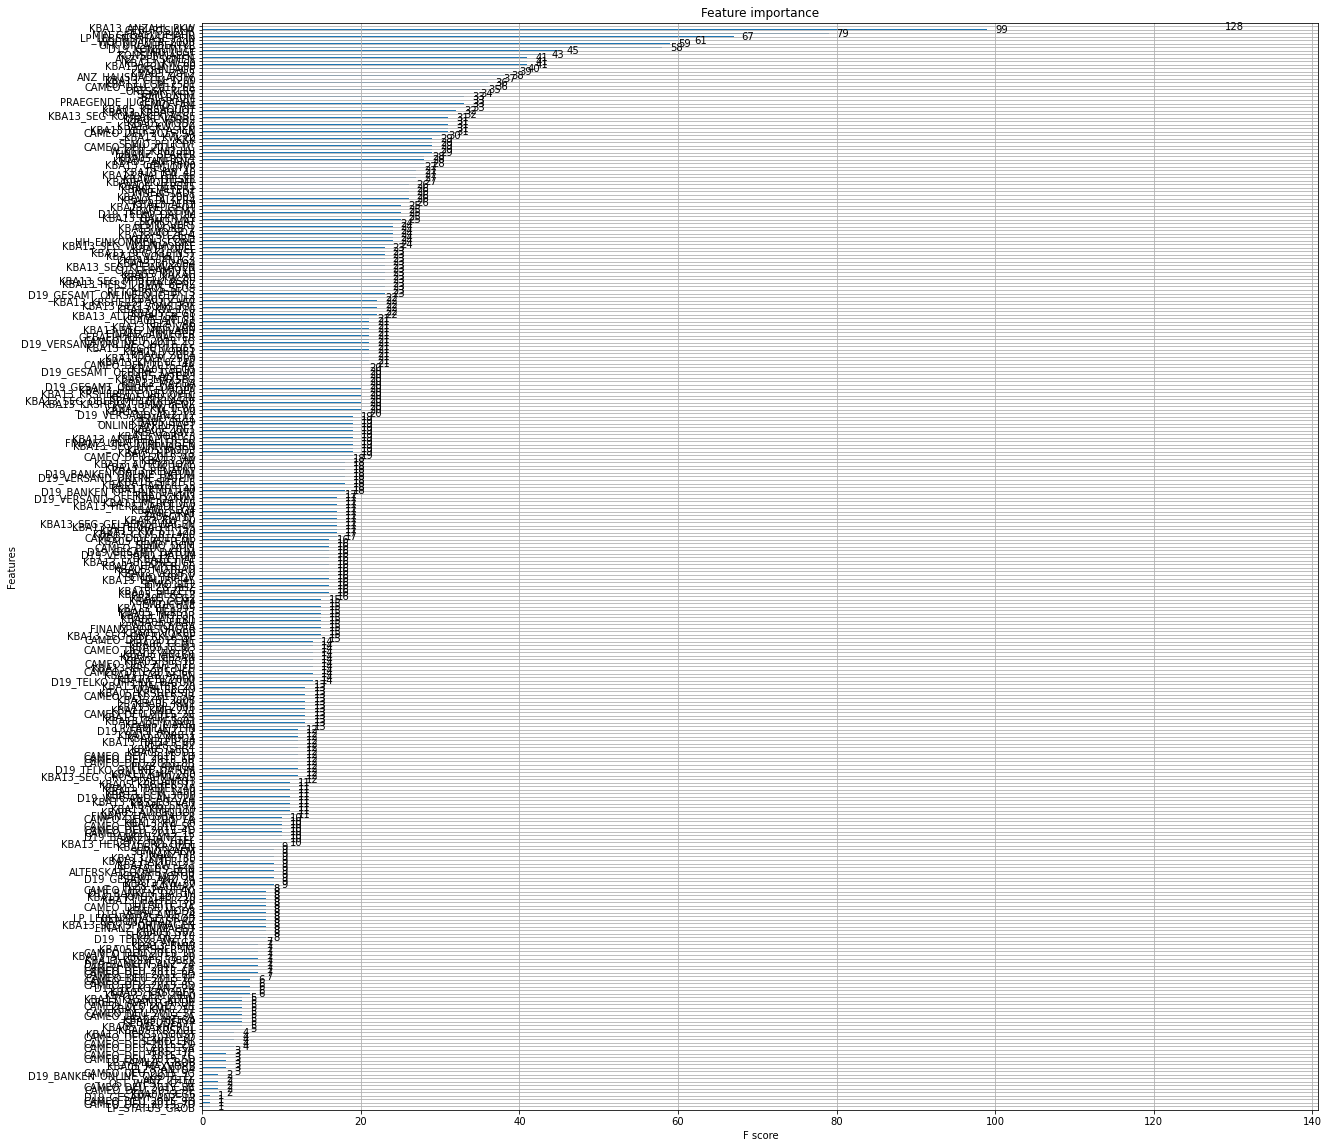

In [82]:
xgb.plot_importance(xgb2)
plt.rcParams['figure.figsize']=[60,40]

In [78]:
test_labels = xgb2.predict(test_features_im)

submission = pd.DataFrame(test_labels, index=test_lrn.astype('int32'),
                         columns=['RESPONSE'])

In [79]:
submission.head()

,RESPONSE
LNR,
1754,0.614289
1770,0.733246
1465,0.201523
1470,0.242363
1478,0.339233


In [80]:
submission[submission['RESPONSE'] > 0.03]

,RESPONSE
LNR,
1754,0.614289
1770,0.733246
1465,0.201523
1470,0.242363
1478,0.339233
...,...
67615,0.576314
67938,0.737361
67942,0.515970


In [81]:
# Save the file for submission.
submission.to_csv('submission.csv')